### Universidad del Valle de Guatemala
### Security Data Science
##### Laboratorio 4 SDS

- Eduardo Ramirez 19946


In [32]:
import os
import re
import ast
import pefile
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, jaccard_score

In [9]:
import os
import pefile
import re
import pandas as pd

ruta_carpeta = './MALWR/MALWR/'

data = []

for nombre_archivo in os.listdir(ruta_carpeta):
    ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)
    if os.path.isfile(ruta_archivo):
        pe = pefile.PE(ruta_archivo)

        file_data = {
            'Nombre del archivo': nombre_archivo,
            'Secciones': [],
            'Funciones': [],
            'Cadenas de texto': [],
            'Recursos': [],
            'Firmas digitales': []
        }

        file_data['Nombre del archivo'] = pe.FILE_HEADER

        for section in pe.sections:
            file_data['Secciones'].append(section.Name.decode().rstrip('\x00'))

        for entry in pe.DIRECTORY_ENTRY_IMPORT:
            dll_functions = {'DLL': entry.dll.decode(), 'Funciones': []}
            for imp in entry.imports:
                dll_functions['Funciones'].append({
                    'Dirección': hex(imp.address),
                    'Nombre de función': imp.name.decode() if imp.name else ''
                })
            file_data['Funciones'].append(dll_functions)

        file_data['Cadenas de texto'] = list(re.findall(b"[A-Za-z0-9/\-:.,_$%'()[\]<> ]{3,}", pe.__data__))

        if hasattr(pe, 'DIRECTORY_ENTRY_RESOURCE'):
            for resource_type in pe.DIRECTORY_ENTRY_RESOURCE.entries:
                if resource_type.name is not None:
                    file_data['Recursos'].append(resource_type.name.decode('utf-8', 'ignore'))
                else:
                    file_data['Recursos'].append(pefile.RESOURCE_TYPE.get(resource_type.struct.Id))

        if hasattr(pe, 'VS_VERSIONINFO'):
            if hasattr(pe, 'FileInfo'):
                for fileinfo in pe.FileInfo:
                    if hasattr(fileinfo, 'StringTable'):
                        for st in fileinfo.StringTable:
                            for entry in st.entries.items():
                                file_data['Firmas digitales'].append(entry)

        data.append(file_data)

df = pd.DataFrame(data)

df.to_csv('malwr.csv', index=False)


Nombre del archivo:  [IMAGE_FILE_HEADER]
0xEC       0x0   Machine:                       0x14C     
0xEE       0x2   NumberOfSections:              0x3       
0xF0       0x4   TimeDateStamp:                 0x4B50A3F8 [Fri Jan 15 17:20:56 2010 UTC]
0xF4       0x8   PointerToSymbolTable:          0x0       
0xF8       0xC   NumberOfSymbols:               0x0       
0xFC       0x10  SizeOfOptionalHeader:          0xE0      
0xFE       0x12  Characteristics:               0x10F     
UPX0
UPX1
.rsrc
DLL:  KERNEL32.DLL
	 0x4070bc LoadLibraryA
	 0x4070c0 ExitProcess
	 0x4070c4 GetProcAddress
	 0x4070c8 VirtualProtect
DLL:  MSVCRT.dll
	 0x4070d0 atol
DLL:  USER32.dll
	 0x4070d8 LoadStringA
DLL:  WS2_32.dll
	 0x4070e0 send
Cadenas de texto:  [b'This program cannot be run in DOS mode.', b'Rich', b'UPX0', b'UPX1', b'.rsrc', b'3.96', b'UPX', b'tpW', b'PQR', b'RSU', b'VWS.', b'oWA', b'L40', b'$XJ', b'RPX48', b"'FE", b'w0fi', b'N8/', b'3XeX', b'rDQP', b'(hT', b'uXj', b't1a', b']USh', b'<CS', b'V3P'

El código anterior fue desarrollado con los siguientes objetivos:

Carga de datos desde un archivo CSV: El script importa un archivo CSV denominado 'malwr.csv' y lo almacena en un DataFrame de Pandas bajo el nombre df.
Transformación de cadenas de texto a estructuras de datos: Se realiza una conversión de todas las columnas que contienen datos en formato de texto a listas y diccionarios, haciendo uso de la función ast.literal_eval().
Representación de características en forma numérica: Para las columnas 'Secciones' y 'Recursos', se emplea la clase MultiLabelBinarizer() de scikit-learn. Esto permite transformar las listas de datos en vectores binarios, lo que facilita su posterior procesamiento algorítmico.
Extracción y conservación de nombres de funciones: Se extraen los nombres de las funciones de la lista de funciones, manteniendo únicamente dichos nombres para su posterior tratamiento.
Codificación de nombres de funciones en vectores de características: Al igual que en el punto anterior, las listas de nombres de funciones se transforman en vectores binarios de características.
Reducción de listas de cadenas de texto a cadenas únicas: Se realiza la conversión de las listas de cadenas de texto a cadenas únicas, para cada entrada presente en la columna 'Cadenas de texto'.
Vectorización de texto: Se utiliza la herramienta TfidfVectorizer de scikit-learn para convertir las cadenas de texto en vectores numéricos, lo que permite su procesamiento eficiente en algoritmos de aprendizaje automático.
Eliminación de columnas no relevantes: Se descartan aquellas columnas que contienen firmas digitales, en caso de estar presentes en el DataFrame, para simplificar el conjunto de datos.
Almacenamiento del conjunto de datos procesado: Finalmente, se guarda el DataFrame procesado en un nuevo archivo CSV denominado 'malwr.csv', el cual está listo para su posterior análisis y transformación.


In [10]:
# Lectura del archivo 'malwr.csv' y conversión de columnas de texto a listas y diccionarios
df = pd.read_csv('malwr.csv')

# Conversión de columnas de texto a estructuras de datos
for columna in ['Secciones', 'Funciones', 'Cadenas de texto', 'Recursos', 'Firmas digitales']:
    df[columna] = df[columna].apply(ast.literal_eval)

# Transformación de listas en vectores binarios de características para 'Secciones' y 'Recursos'
mlb = MultiLabelBinarizer()
for columna in ['Secciones', 'Recursos']:
    transformed_data = pd.DataFrame(mlb.fit_transform(df.pop(columna)),
                                    columns=mlb.classes_,
                                    index=df.index)
    df = df.join(transformed_data)

# Extracción de nombres de funciones y transformación en vectores de características
df['Funciones'] = df['Funciones'].apply(lambda x: [func['Función'] for func in x])
mlb = MultiLabelBinarizer()
function_data = pd.DataFrame(mlb.fit_transform(df.pop('Funciones')),
                             columns=mlb.classes_,
                             index=df.index)
df = df.join(function_data.add_prefix('Función_'))

# Conversión de listas de cadenas de texto a cadenas únicas
df['Cadenas de texto'] = df['Cadenas de texto'].apply(lambda x: ' '.join([s.decode('utf-8', 'ignore') for s in x]))

# Vectorización de cadenas de texto
vectorizer = TfidfVectorizer(max_features=1000)
text_data = pd.DataFrame(vectorizer.fit_transform(df.pop('Cadenas de texto')).toarray(),
                         columns=vectorizer.get_feature_names_out(),
                         index=df.index)
df = df.join(text_data.add_prefix('Texto_'))

# Eliminación de la columna 'Firmas digitales' si existe y guardado del conjunto de datos procesado en 'malwr_data.csv'
if 'Firmas digitales' in df.columns:
    df = df.drop('Firmas digitales', axis=1)

df.to_csv('malwr_data.csv', index=False)


# Aplicando algoritmos

In [4]:
df = pd.read_csv('malwr_data.csv')

X = df.drop('Nombre', axis=1)

## Algoritmo de KMeans


El proceso comienza con la carga de un archivo CSV llamado 'malwr.csv' en un DataFrame de Pandas denominado df. Luego, se aplica la función ast.literal_eval() para convertir las cadenas de texto en listas y diccionarios, facilitando así su manipulación.

Una vez convertidos, las listas de las columnas 'Secciones' y 'Recursos' se transforman en vectores binarios de características mediante la clase MultiLabelBinarizer y su método fit_transform(), lo que permite representar estas características numéricamente para su posterior análisis.

En paralelo, se extraen los nombres de las funciones de la lista de funciones, manteniendo únicamente los nombres para su procesamiento. Estos nombres de funciones se transforman también en vectores binarios de características mediante MultiLabelBinarizer().

Posteriormente, las listas de cadenas de texto se convierten en una única cadena de texto, uniendo todas las cadenas con un espacio entre cada una.

Para vectorizar las cadenas de texto convertidas, se emplea TfidfVectorizer de scikit-learn, lo que permite representarlas de manera numérica y adecuada para su procesamiento en algoritmos de aprendizaje automático, estableciendo un límite máximo de características en 1000.

Si la columna 'Firmas digitales' está presente en el DataFrame, se elimina, y finalmente, el DataFrame procesado se guarda en un nuevo archivo CSV llamado 'malwr_data.csv' para su uso futuro en modelos de aprendizaje automático.

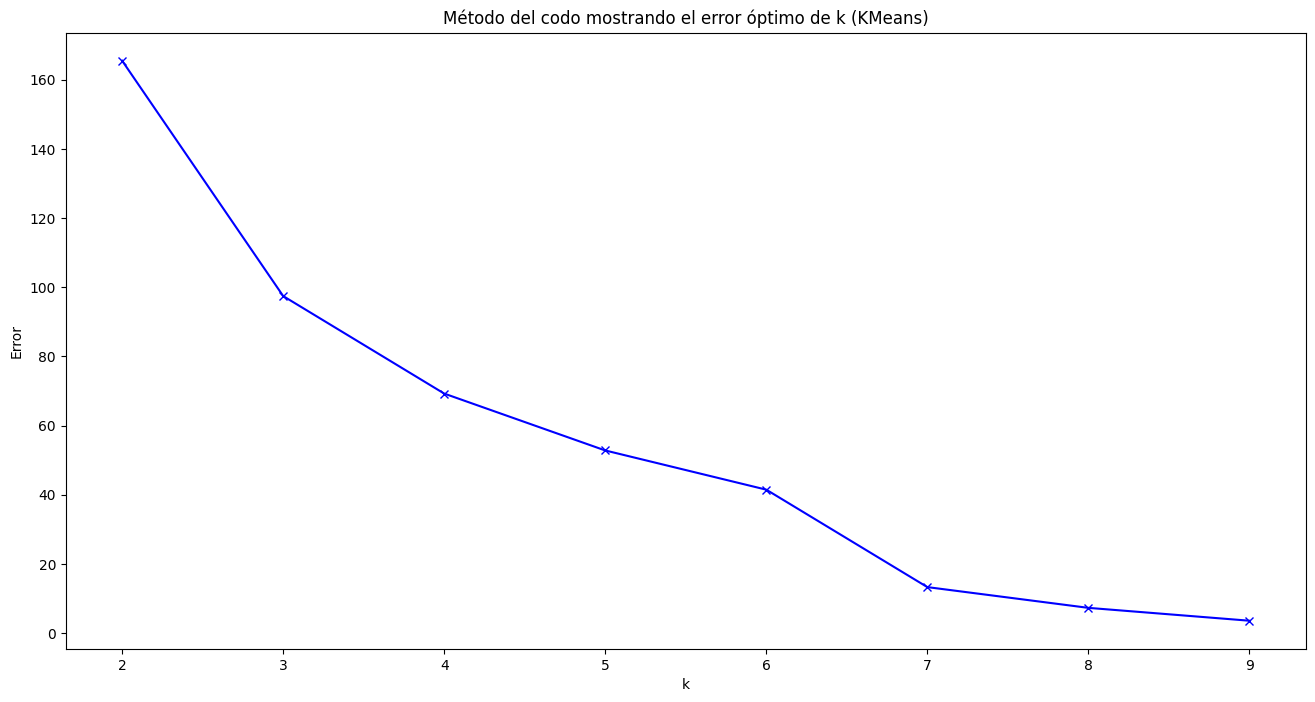

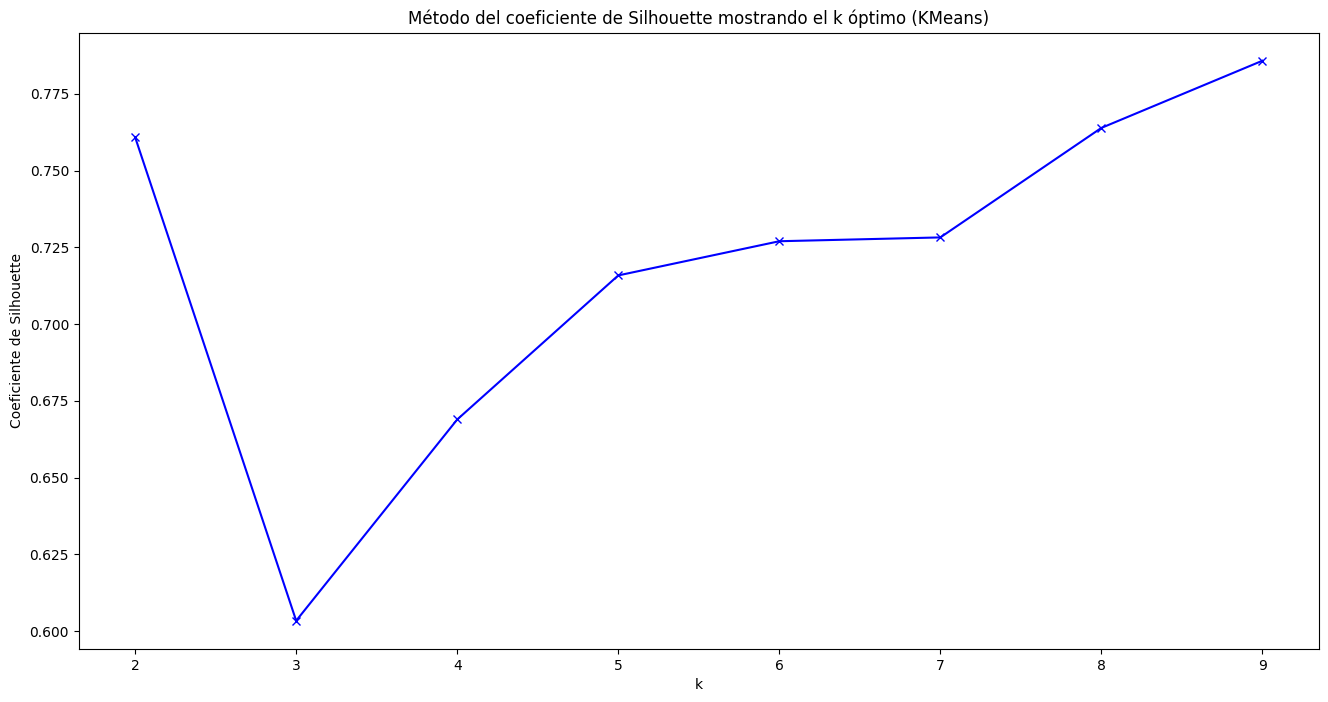

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def find_optimal_clusters(X, min_clusters=2, max_clusters=10):
    errores_kmeans = []
    silhouettes_kmeans = []

    K = range(min_clusters, max_clusters)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)

        error = kmeans.inertia_
        errores_kmeans.append(error)

        silhouette = silhouette_score(X, kmeans.labels_)
        silhouettes_kmeans.append(silhouette)

    plt.figure(figsize=(16,8))
    plt.plot(K, errores_kmeans, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Error')
    plt.title('Método del codo mostrando el error óptimo de k (KMeans)')
    plt.show()

    plt.figure(figsize=(16,8))
    plt.plot(K, silhouettes_kmeans, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Coeficiente de Silhouette')
    plt.title('Método del coeficiente de Silhouette mostrando el k óptimo (KMeans)')
    plt.show()



Según el análisis de las gráficas, se observa que los valores óptimos de k, tanto en el método del codo como en el coeficiente de Silhouette, varían entre 2 y 4. Sin embargo, la distribución de los coeficientes de Silhouette no es uniforme, lo que indica que algunos valores de k podrían ser más apropiados que otros en términos de la separación y cohesión de los clústeres.

Considerando esta información, se sugiere que el número óptimo de clústeres para este modelo estaría entre 2 y 3. Esto se basa en la búsqueda de un rendimiento superior que pueda conducir a una detección más efectiva del malware durante el análisis realizado por un antivirus. En resumen, estos valores de k podrían proporcionar un equilibrio adecuado entre la capacidad de distinguir entre diferentes tipos de malware y la cohesión dentro de cada clúster para una clasificación precisa.

Reductor de dimensionalidad de los datos analizados

In [6]:

pca = PCA(n_components=2)
X_2D = pca.fit_transform(X)

Gráfico de dispersión de KMeans

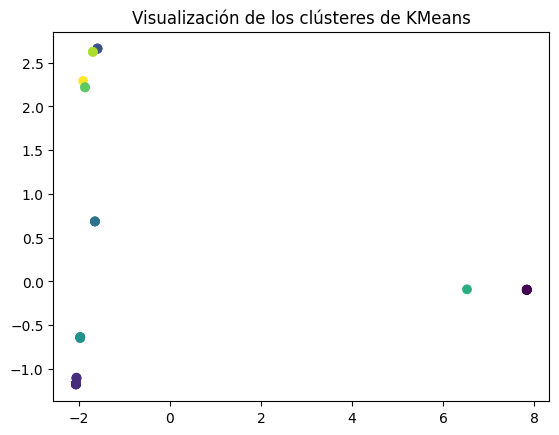

In [7]:

plt.scatter(X_2D[:, 0], X_2D[:, 1], c=df['Etiqueta_KMeans'])
plt.title('Visualización de los clústeres de KMeans')
plt.show()


La gráfica destaca dos aspectos cruciales:

El primer clúster parece reunir las características distintivas de una familia específica de malware. Por otro lado, el clúster 3 podría contener observaciones de malware que comparten similitudes en términos de encabezados, contenido y otros aspectos.
El clúster 2 probablemente alberga una familia de malware que no comparte ninguna característica identificable con las familias de malware observadas y analizadas en los clústeres 1 y 3. Esto sugiere la presencia de una clase de malware única o poco común, que no se ajusta a los patrones identificados en las otras dos familias de malware.

## Método de AgglomerativeClustering

Se comienza inicializando dos listas vacías, inercias_agglo y silhouettes_agglo, para almacenar las inercias y coeficientes de Silhouette correspondientes a diferentes valores de K.
Luego, se itera sobre cada valor de K en el rango especificado.
Para cada valor de K, se crea un modelo AgglomerativeClustering con el número correspondiente de clústeres y se ajusta a los datos de entrada X.
Se calcula la "inercia" del modelo ajustado, que representa la suma de las distancias euclidianas entre todos los pares de puntos dentro de cada clúster, dividida por el doble del tamaño del clúster.
La inercia calculada se agrega a la lista inercias_agglo.
Se calcula el coeficiente de Silhouette del modelo ajustado utilizando la función silhouette_score de scikit-learn.
El coeficiente de Silhouette calculado se agrega a la lista silhouettes_agglo.
Las observaciones en el DataFrame df se etiquetan según los clústeres indicados por el modelo AgglomerativeClustering.
Finalmente, se generan dos gráficos para visualizar los resultados del análisis:a. Método del codo: muestra la inercia en función del número de clústeres (K), ayudando a identificar el punto donde la tasa de disminución de la inercia se estabiliza, lo que sugiere un número óptimo de clústeres.b. Método del coeficiente de Silhouette: muestra el coeficiente de Silhouette en función del número de clústeres (K), permitiendo identificar el valor óptimo de K que maximiza la cohesión intraclúster y la separación interclúster.

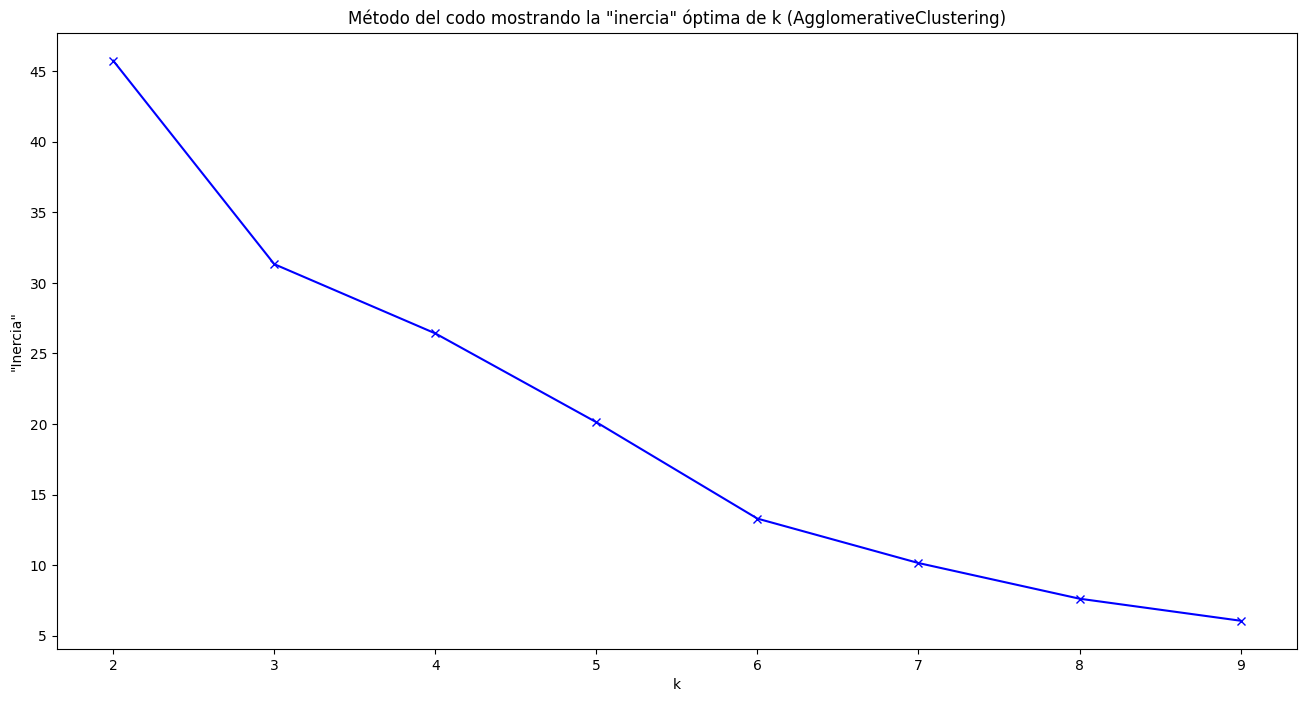

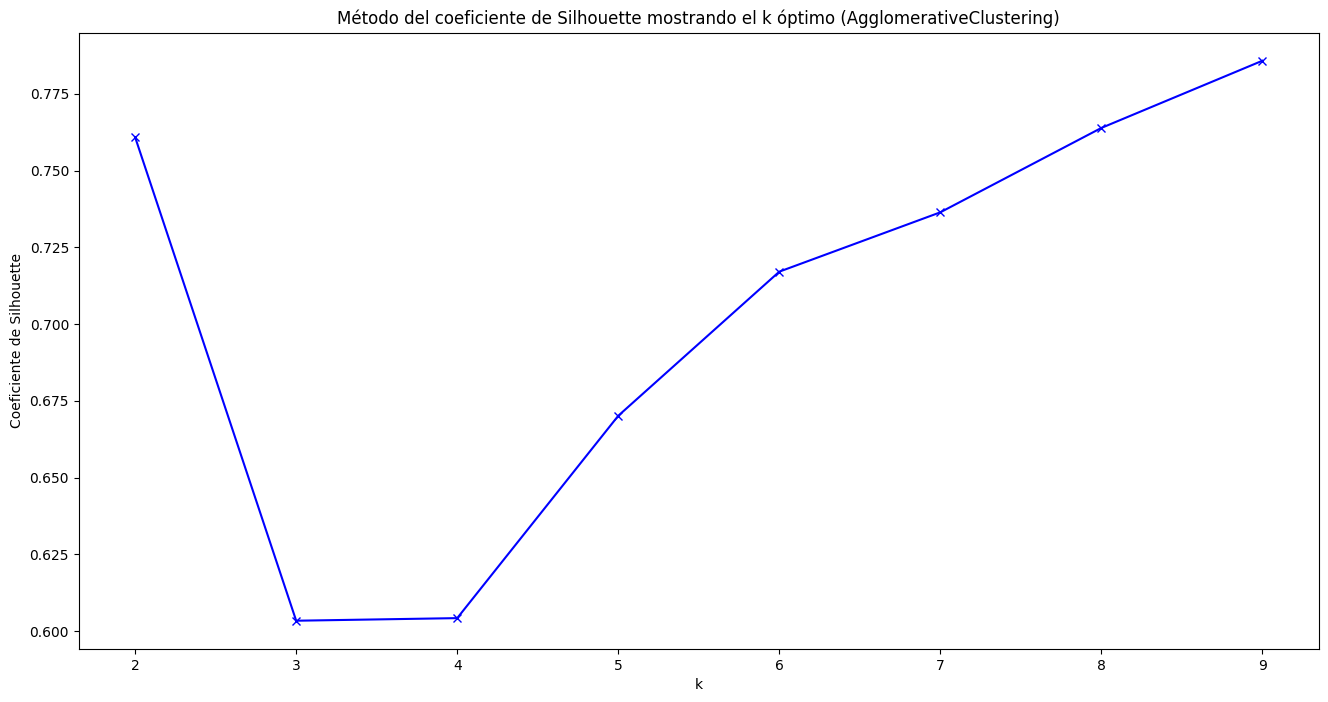

In [8]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

inercias_agglo = []
silhouettes_agglo = []

for k in K:
    agglo = AgglomerativeClustering(n_clusters=k)
    labels = agglo.fit_predict(X)

    inercia = 0
    for cluster_id in range(k):
        cluster_samples = X[labels == cluster_id]
        if len(cluster_samples) > 1:
            dist_matrix = euclidean_distances(cluster_samples)
            inercia += dist_matrix.sum() / (2 * len(cluster_samples))
    inercias_agglo.append(inercia)

    silhouette = silhouette_score(X, labels)
    silhouettes_agglo.append(silhouette)

plt.figure(figsize=(16,8))
plt.plot(K, inercias_agglo, 'bx-')
plt.xlabel('k')
plt.ylabel('"Inercia"')
plt.title('Método del codo mostrando la "inercia" óptima de k (AgglomerativeClustering)')
plt.show()

plt.figure(figsize=(16,8))
plt.plot(K, silhouettes_agglo, 'bx-')
plt.xlabel('k')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Método del coeficiente de Silhouette mostrando el k óptimo (AgglomerativeClustering)')
plt.show()


El análisis revela que, según el método del codo, el número óptimo de clústeres para este modelo parece estar entre 2 y 3, siendo 3 el valor óptimo identificado. Sin embargo, al considerar el coeficiente de Silhouette:

Para k = 2, aunque hay una alta concentración de valores del coeficiente alrededor de 0.5, también se observan algunas observaciones con valores bajos, lo que sugiere cierta falta de cohesión en los clústeres.
Para k = 3, la distribución del coeficiente de Silhouette es más heterogénea, con valores bastante similares, lo que indica una separación razonable entre clústeres pero posiblemente una menor cohesión intraclúster.
Para k mayores a 3, los valores del coeficiente de Silhouette no parecen proporcionar agrupaciones adecuadas para detectar las familias de malware y su peligrosidad, ya que la cohesión intraclúster podría ser insuficiente.
En resumen, aunque el método del codo sugiere un valor óptimo de k = 3, la evaluación del coeficiente de Silhouette sugiere que tanto k = 2 como k = 3 podrían ser opciones válidas, cada una con sus propias implicaciones en términos de la cohesión y separación de los clústeres.

Gráfico de dispersión de AgglomerativeClustering

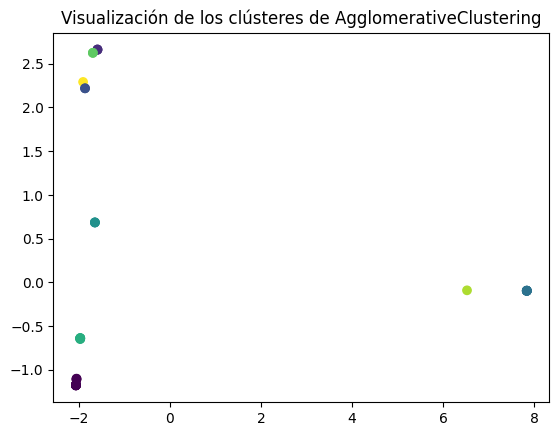

In [9]:
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=df['Etiqueta_Agglo'])
plt.title('Visualización de los clústeres de AgglomerativeClustering')
plt.show()


En la gráfica de dispersión, al igual que en la anterior, se pueden identificar dos observaciones destacadas:

El primer clúster reúne dos familias de malware que muestran una notable similitud o incluso podrían ser idénticas entre sí.
En contraste, el último clúster contiene una familia de malware que se encuentra completamente aislada de las demás, sin mostrar similitudes aparentes con las demás familias.

## Índice de Jaccard

Nodo 0 y nodo 6 tienen similitud 0.865979381443299
Nodo 0 y nodo 11 tienen similitud 0.9333333333333333
Nodo 0 y nodo 15 tienen similitud 0.8526315789473684
Nodo 0 y nodo 16 tienen similitud 0.8817204301075269
Nodo 0 y nodo 21 tienen similitud 0.9021739130434783
Nodo 1 y nodo 2 tienen similitud 0.9903846153846154
Nodo 1 y nodo 3 tienen similitud 0.5384615384615384
Nodo 1 y nodo 4 tienen similitud 0.535031847133758
Nodo 1 y nodo 5 tienen similitud 0.5256410256410257
Nodo 1 y nodo 7 tienen similitud 0.8738738738738738
Nodo 1 y nodo 8 tienen similitud 0.5454545454545454
Nodo 1 y nodo 13 tienen similitud 0.5490196078431373
Nodo 1 y nodo 17 tienen similitud 0.5316455696202531
Nodo 1 y nodo 18 tienen similitud 0.5189873417721519
Nodo 1 y nodo 20 tienen similitud 0.5294117647058824
Nodo 1 y nodo 24 tienen similitud 0.5225806451612903
Nodo 1 y nodo 25 tienen similitud 0.5253164556962026
Nodo 1 y nodo 26 tienen similitud 0.5448717948717948
Nodo 1 y nodo 30 tienen similitud 0.5290322580645161
No

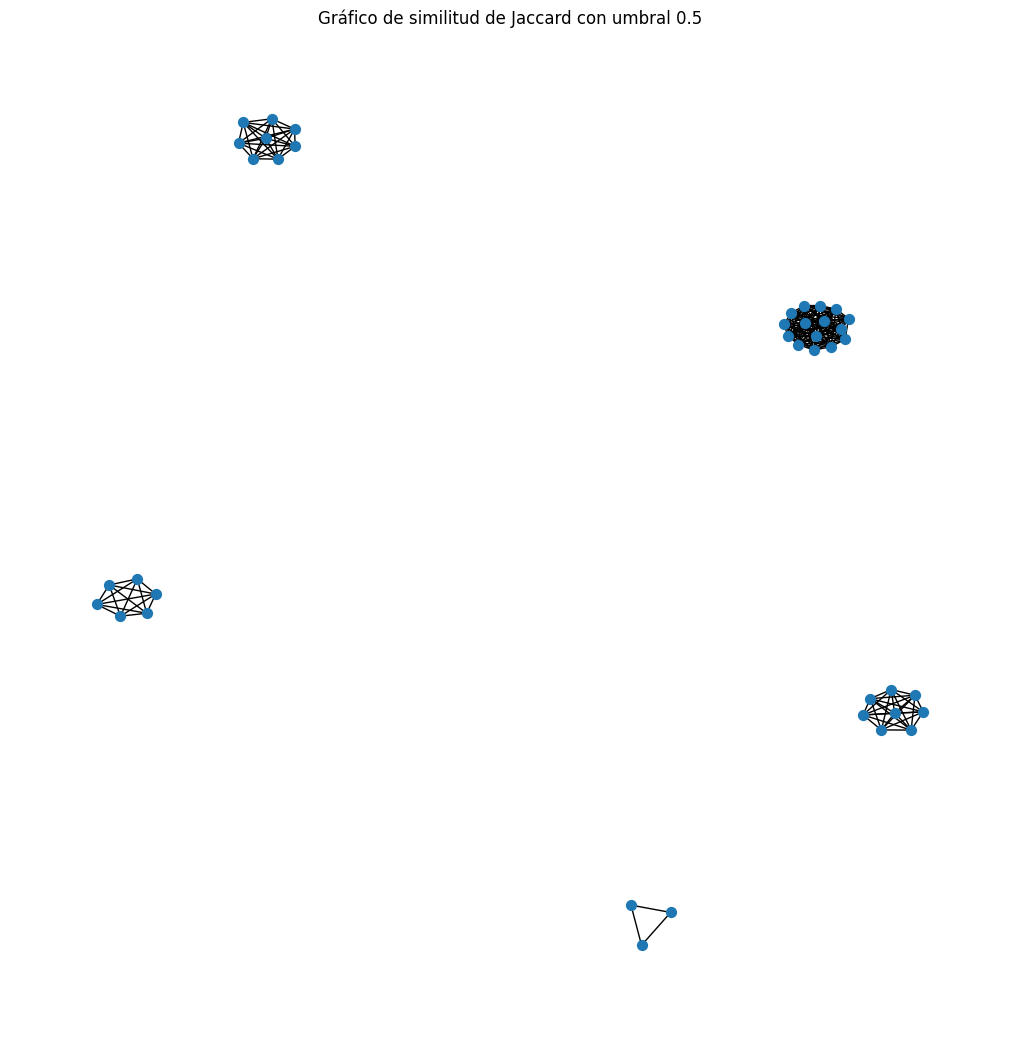

Nodo 0 y nodo 6 tienen similitud 0.865979381443299
Nodo 0 y nodo 11 tienen similitud 0.9333333333333333
Nodo 0 y nodo 15 tienen similitud 0.8526315789473684
Nodo 0 y nodo 16 tienen similitud 0.8817204301075269
Nodo 0 y nodo 21 tienen similitud 0.9021739130434783
Nodo 1 y nodo 2 tienen similitud 0.9903846153846154
Nodo 1 y nodo 7 tienen similitud 0.8738738738738738
Nodo 2 y nodo 7 tienen similitud 0.8660714285714286
Nodo 3 y nodo 4 tienen similitud 0.9366197183098591
Nodo 3 y nodo 5 tienen similitud 0.9290780141843972
Nodo 3 y nodo 8 tienen similitud 0.9428571428571428
Nodo 3 y nodo 13 tienen similitud 0.9219858156028369
Nodo 3 y nodo 17 tienen similitud 0.9436619718309859
Nodo 3 y nodo 18 tienen similitud 0.9295774647887324
Nodo 3 y nodo 20 tienen similitud 0.8873239436619719
Nodo 3 y nodo 24 tienen similitud 0.9424460431654677
Nodo 3 y nodo 25 tienen similitud 0.9230769230769231
Nodo 3 y nodo 26 tienen similitud 0.9642857142857143
Nodo 3 y nodo 30 tienen similitud 0.9637681159420289
N

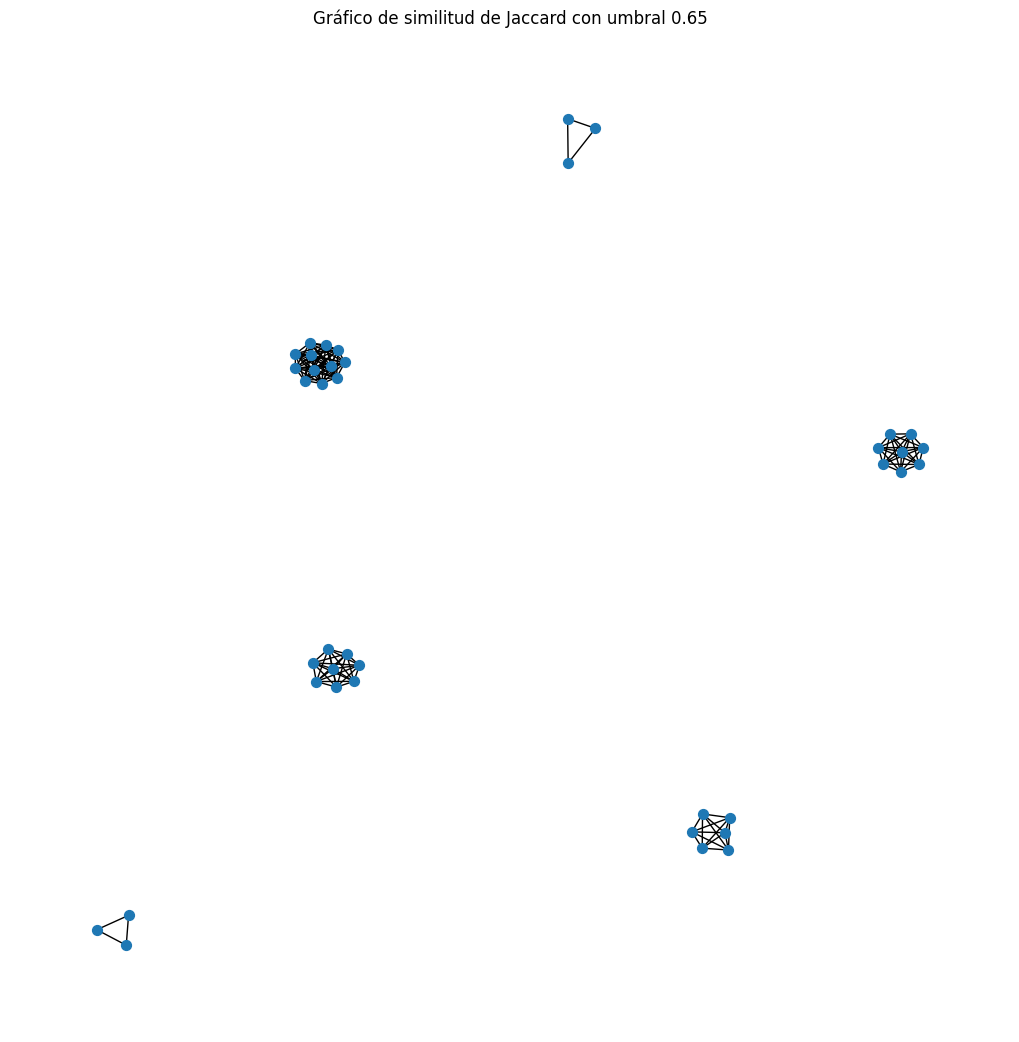

Nodo 0 y nodo 11 tienen similitud 0.9333333333333333
Nodo 1 y nodo 2 tienen similitud 0.9903846153846154
Nodo 3 y nodo 4 tienen similitud 0.9366197183098591
Nodo 3 y nodo 8 tienen similitud 0.9428571428571428
Nodo 3 y nodo 17 tienen similitud 0.9436619718309859
Nodo 3 y nodo 24 tienen similitud 0.9424460431654677
Nodo 3 y nodo 26 tienen similitud 0.9642857142857143
Nodo 3 y nodo 30 tienen similitud 0.9637681159420289
Nodo 4 y nodo 5 tienen similitud 0.9640287769784173
Nodo 4 y nodo 8 tienen similitud 0.9640287769784173
Nodo 4 y nodo 13 tienen similitud 0.9568345323741008
Nodo 4 y nodo 17 tienen similitud 0.9507042253521126
Nodo 4 y nodo 18 tienen similitud 0.9784172661870504
Nodo 4 y nodo 25 tienen similitud 0.9714285714285714
Nodo 4 y nodo 26 tienen similitud 0.9574468085106383
Nodo 4 y nodo 30 tienen similitud 0.9428571428571428
Nodo 5 y nodo 8 tienen similitud 0.9708029197080292
Nodo 5 y nodo 13 tienen similitud 0.935251798561151
Nodo 5 y nodo 17 tienen similitud 0.9432624113475178


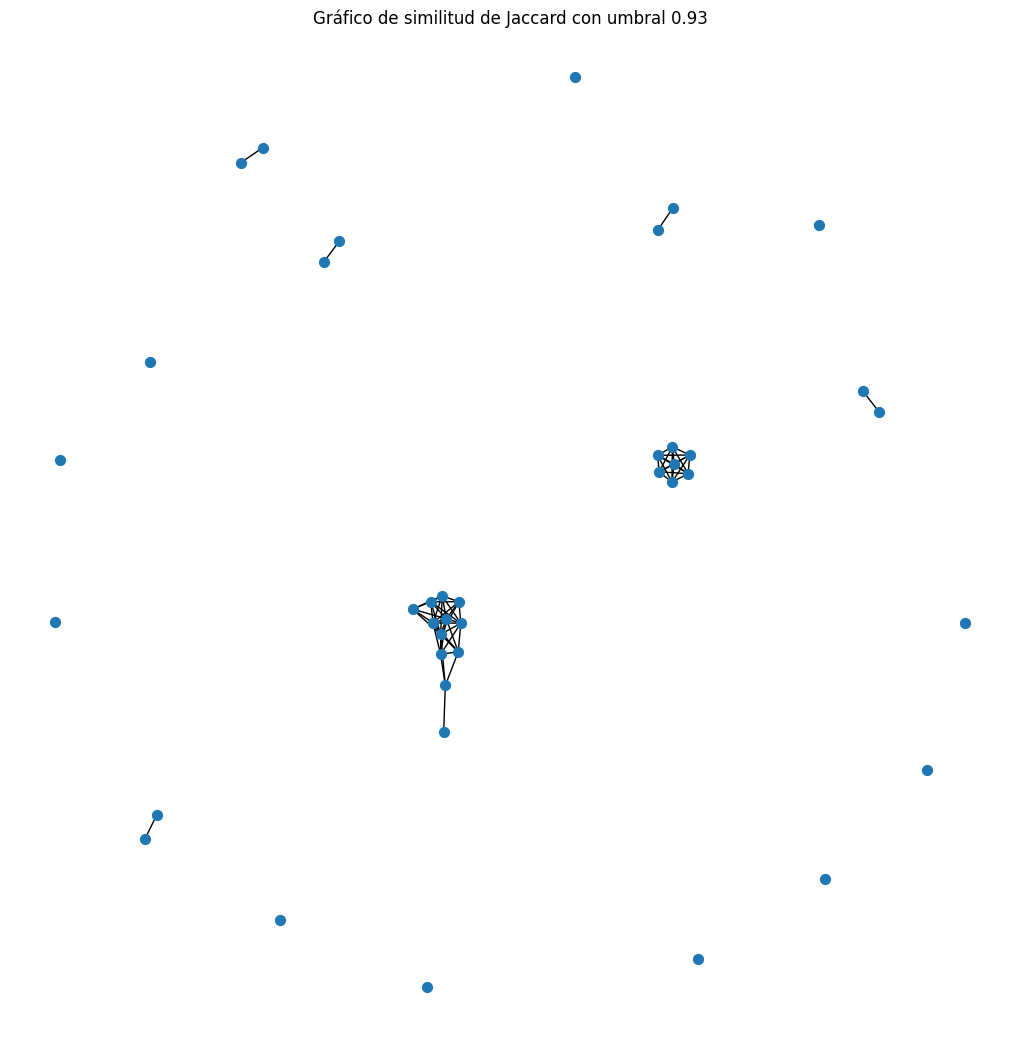

In [65]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import jaccard_score
import pandas as pd

def plot_jaccard_similarity_graphs(df, thresholds):
    for threshold in thresholds:
        G = nx.Graph()

        for i in range(len(df)):
            G.add_node(i)

        for i in range(len(df)):
            for j in range(i+1, len(df)):
                a_binary = [1 if value else 0 for value in df.iloc[i]]
                b_binary = [1 if value else 0 for value in df.iloc[j]]

                similarity = jaccard_score(a_binary, b_binary, average='binary')

                if similarity > threshold:
                    G.add_edge(i, j)

        plt.figure(figsize=(10, 10))
        nx.draw(G, node_size=50, width=1)
        plt.title(f'Gráfico de similitud de Jaccard con umbral {threshold}')
        plt.show()

# Uso de la función con los datos y umbrales proporcionados
df = pd.read_csv('malwr_data.csv')
thresholds = [0.5, 0.65, 0.93]
plot_jaccard_similarity_graphs(df, thresholds)


## Conclusiones

Para ambos algoritmos, se observa que el coeficiente de Silhouette alcanza su valor más alto cuando se utilizan 9 clústeres. Este patrón se mantiene consistente independientemente del algoritmo utilizado, lo que sugiere que los datos de malware pueden estar bastante dispersos en funcionalidades, pero también pueden ser variantes de una familia de malware original.

Tanto el coeficiente de Silhouette como el método del codo muestran una "estabilidad" en el número de clústeres alrededor de 4 a 5 agrupaciones. Esta coincidencia indica que estos valores podrían representar un equilibrio entre la cohesión intraclúster y la separación interclúster, lo que sugiere una estructura natural en los datos.

A partir de los resultados obtenidos, parece haber 4 familias distintas entre los ejemplares de malware proporcionados. Esta conclusión se basa en la observación de que, aunque hay algunos grupos más pequeños, estos grupos no crecen significativamente al aumentar el umbral de similitud, lo que sugiere que podrían contener ejemplares con características ligeramente diferentes pero no lo suficientemente distintas como para formar una nueva familia de malware.

El análisis de similitud muestra un comportamiento similar al de los algoritmos de partición en cuanto a la cantidad de familias encontradas. Aunque las representaciones de los grupos pueden variar ligeramente entre el análisis de similitud basado en strings y el análisis basado en llamadas a funciones, ambos métodos producen resultados que sugieren la existencia de una cantidad similar de familias de malware en los datos.
